# Causal Bayesian Network tutorial

This notebook covers how to specify the graphical structure and causal/probabilistic relationships of CBNs in PyCID, and how to answer causal, probabilistic, and graphical queries.

To open this notebook in Google Colab, click the following link:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/causalincentives/pycid/blob/master/notebooks/CBN_Tutorial.ipynb)

In [1]:
# importing necessary libraries
try:
    import pycid
except ModuleNotFoundError:
    import sys

    !{sys.executable} -m pip install git+https://github.com/causalincentives/pycid # for the latest development version
    import pycid

import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Graphical Structure

The structure of a CBN is specified by a list of edges. This implicitly specifies the nodes as well.

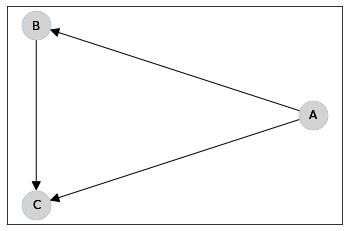

In [2]:
cbn = pycid.CausalBayesianNetwork(
    [("A", "B"), ("A", "C"), ("B", "C")],  # specifies the MAICD's nodes and edges.
)

cbn.draw()

## 2. Distributions

PyCID is designed to make it easy to quickly specify causal and probabilistic relationships between nodes in a DAG.

Distributions are represented with dictionaries `{outcome: P(outcome)}` that have possible outcomes as keys, and the probability of the outcome as value. For example, a Bernoulli(0.6) distribution can be represented as `{0: 0.4, 1: 0.6}`.

We can add such a distribution to the node A in the network we just specified.

In [3]:
cbn.model["A"] = {0: 0.4, 1: 0.6}
# alternatively: cbn.model['A'] = pycid.bernoulli(0.6)

# print it as a probability table
print(cbn.get_cpds("A").prob_table())

+------+-----+
| A(0) | 0.4 |
+------+-----+
| A(1) | 0.6 |
+------+-----+


## 3. Conditional distributions

Conditional distributions can be specified with functions that return distribution-dictionaries, and whose arguments match the names of the parent variables. For example, we can specify that B is a Bernoulli distribution whose parameter depends on A, say as B ~ Bernoulli((1+A)/3), via

In [4]:
cbn.model["B"] = lambda A: pycid.bernoulli((1 + A) / 3)

print("We can see the result in a few different ways:")
print("\nThe model object contains just what we added:")
print(cbn.model["B"])
print("\nThe CPD has interpreted it as a stochastic function:")
print(cbn.get_cpds("B"))
print("\nAnd as a probability table")
print(cbn.get_cpds("B").prob_table())

We can see the result in a few different ways:

The model object contains just what we added:
<function <lambda> at 0x7fc0576623b0>

The CPD has interpreted it as a stochastic function:
StochasticFunctionCPD<B> 
{'A': 0}  ->  {0: 0.6666666666666667, 1: 0.3333333333333333}
{'A': 1}  ->  {0: 0.33333333333333337, 1: 0.6666666666666666}

And as a probability table
+------+--------------------+---------------------+
| A    | A(0)               | A(1)                |
+------+--------------------+---------------------+
| B(0) | 0.6666666666666667 | 0.33333333333333337 |
+------+--------------------+---------------------+
| B(1) | 0.3333333333333333 | 0.6666666666666666  |
+------+--------------------+---------------------+


Arbitrary stochastic relationships can be specified with inline if-else statements. For example, we can specify the distribution for C based on the different outcomes for A and B as follows

In [5]:
cbn.model["C"] = lambda A, B: (
    pycid.bernoulli(0.2)
    if A == 0 and B == 0
    else pycid.bernoulli(0.3)
    if A == 0 and B == 1
    else pycid.bernoulli(0.4)
    if A == 1 and B == 0
    else pycid.bernoulli(0.5)
)

print("As a stochastic function:")
print(cbn.get_cpds("C"))
print("\nAs a probability table")
print(cbn.get_cpds("C").prob_table())

As a stochastic function:
StochasticFunctionCPD<C> 
{'A': 0, 'B': 0}  ->  {0: 0.8, 1: 0.2}
{'A': 0, 'B': 1}  ->  {0: 0.7, 1: 0.3}
{'A': 1, 'B': 0}  ->  {0: 0.6, 1: 0.4}
{'A': 1, 'B': 1}  ->  {0: 0.5, 1: 0.5}

As a probability table
+------+------+------+------+------+
| A    | A(0) | A(0) | A(1) | A(1) |
+------+------+------+------+------+
| B    | B(0) | B(1) | B(0) | B(1) |
+------+------+------+------+------+
| C(0) | 0.8  | 0.7  | 0.6  | 0.5  |
+------+------+------+------+------+
| C(1) | 0.2  | 0.3  | 0.4  | 0.5  |
+------+------+------+------+------+


## 4. Conditional distributions -- advanced

Here we cover a few more advanced tricks for specifying probabilistic relationships in PyCID.

### 4.1 Deterministic functions

First, if a function is returning a single value rather than a dictionary, then it is interpreted as a deterministic function, i.e. a degenerate probability distribution. This is useful when specifying structural causal models.

For example, we can specify that B is the inverse of A as follows:

In [6]:
cbn.model["B"] = lambda A: 1 - A

print("\nAs a function:")
print(cbn.get_cpds("B"))
print("\nAs a probability table")
print(cbn.get_cpds("B").prob_table())


As a function:
StochasticFunctionCPD<B> 
{'A': 0}  ->  1
{'A': 1}  ->  0

As a probability table
+------+------+------+
| A    | A(0) | A(1) |
+------+------+------+
| B(0) | 0.0  | 1.0  |
+------+------+------+
| B(1) | 1.0  | 0.0  |
+------+------+------+


### 4.2 Incomplete distributions

If a distribution dictionary contains `None` values, then the remaining probability mass will be spread equally over those keys. For example, we can specify that A has the distribution `{0: 0.6, 1: 0.2, 2: 0.2}` with the dictionary `{0: 0.6, 1: None, 2: None}`:

In [7]:
cbn.model["A"] = {0: 0.6, 1: None, 2: None}
# alternatively: cbn.model['A'] = pycid.bernoulli(0.6)
print("\nAs a stochastic function:")
print(cbn.get_cpds("A"))
print("\nAs a probability table")
print(cbn.get_cpds("A").prob_table())


As a stochastic function:
ConstantCPD<A> 
{}  ->  {0: 0.6, 1: None, 2: None}

As a probability table
+------+-----+
| A(0) | 0.6 |
+------+-----+
| A(1) | 0.2 |
+------+-----+
| A(2) | 0.2 |
+------+-----+


This is especially timesaving when specifying a complicated distribution involving several if-clauses:

In [8]:
cbn.model["C"] = lambda A, B: {
    0: (0.2 if A == 0 and B == 0 else 0.3 if A == 0 and B == 1 else 0.4),
    1: None,
}  # This completes to 1-P(0)

print("As a stochastic function:")
print(cbn.get_cpds("C"))
print("\nAs a probability table")
print(cbn.get_cpds("C").prob_table())

As a stochastic function:
StochasticFunctionCPD<C> 
{'A': 0, 'B': -1}  ->  {0: 0.4, 1: None}
{'A': 0, 'B': 0}  ->  {0: 0.2, 1: None}
{'A': 0, 'B': 1}  ->  {0: 0.3, 1: None}
{'A': 1, 'B': -1}  ->  {0: 0.4, 1: None}
{'A': 1, 'B': 0}  ->  {0: 0.4, 1: None}
{'A': 1, 'B': 1}  ->  {0: 0.4, 1: None}
{'A': 2, 'B': -1}  ->  {0: 0.4, 1: None}
{'A': 2, 'B': 0}  ->  {0: 0.4, 1: None}
{'A': 2, 'B': 1}  ->  {0: 0.4, 1: None}

As a probability table
+------+-------+------+------+-------+------+------+-------+------+------+
| A    | A(0)  | A(0) | A(0) | A(1)  | A(1) | A(1) | A(2)  | A(2) | A(2) |
+------+-------+------+------+-------+------+------+-------+------+------+
| B    | B(-1) | B(0) | B(1) | B(-1) | B(0) | B(1) | B(-1) | B(0) | B(1) |
+------+-------+------+------+-------+------+------+-------+------+------+
| C(0) | 0.4   | 0.2  | 0.3  | 0.4   | 0.4  | 0.4  | 0.4   | 0.4  | 0.4  |
+------+-------+------+------+-------+------+------+-------+------+------+
| C(1) | 0.6   | 0.8  | 0.7  | 0.6  

### 4.3 Incomplete distributions in functions

Sometimes the keys of the dictionary will depend on the arguments to the function. For example, consider the function `lambda A: {A: 0.9}` that makes B a "noisy copy" of A. For any given value of A, it will always output an incomplete dictionary with only a single key, and whose values only sum to 0.9. Even though there are no `None`-keys present, PyCID can still effectively infer the remaining `None`-keys by looking at the keys over different values of A.

In [9]:
cbn.model["B"] = lambda A: {A: 0.9}

print("\nAs a function:")
print(cbn.get_cpds("B"))
print("\nAs a probability table")
print(cbn.get_cpds("B").prob_table())


As a function:
StochasticFunctionCPD<B> 
{'A': 0}  ->  {0: 0.9}
{'A': 1}  ->  {1: 0.9}
{'A': 2}  ->  {2: 0.9}

As a probability table
+------+---------------------+---------------------+---------------------+
| A    | A(0)                | A(1)                | A(2)                |
+------+---------------------+---------------------+---------------------+
| B(0) | 0.9                 | 0.04999999999999999 | 0.04999999999999999 |
+------+---------------------+---------------------+---------------------+
| B(1) | 0.04999999999999999 | 0.9                 | 0.04999999999999999 |
+------+---------------------+---------------------+---------------------+
| B(2) | 0.04999999999999999 | 0.04999999999999999 | 0.9                 |
+------+---------------------+---------------------+---------------------+


When the relationships are simple, they can often be read from the plot as well:

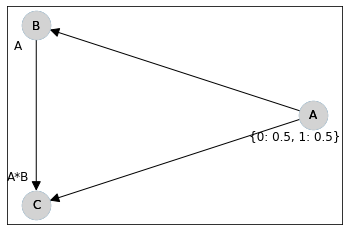

In [10]:
cbn.model.update(A=pycid.bernoulli(0.5), B=lambda A: A, C=lambda A, B: A * B)
cbn.draw()

## 5 Queries, expected value, sampling

Usually, the reason we go through the effort of writing down a model in PyCID is to be able to automatically answer various probabilistic queries about it.

### 5.1 Probabilistic queries

For example, what is the distribution of C given that B=1?

In [11]:
print(cbn.query(["C"], context={"B": 1}))

+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.0000 |
+------+----------+
| C(1) |   1.0000 |
+------+----------+


### 5.2 Expectations

It is also possible to find out the joint distribution of A and C given B=1:

In [12]:
print(cbn.query(["A", "C"], context={"B": 1}))

+------+------+------------+
| A    | C    |   phi(A,C) |
+======+======+============+
| A(0) | C(0) |     0.0000 |
+------+------+------------+
| A(0) | C(1) |     0.0000 |
+------+------+------------+
| A(1) | C(0) |     0.0000 |
+------+------+------------+
| A(1) | C(1) |     1.0000 |
+------+------+------------+


Similarly, we can also query the expected value of C in the given context

In [13]:
print(cbn.expected_value(["C"], context={"B": 1}))

[1.0]


### 5.3 Causal queries

Causal interventions work analogously

In [14]:
print("distribution", cbn.query(["C"], context={"A": 1}, intervention={"B": 0}))
print("expected value", cbn.expected_value(["C"], context={"A": 1}, intervention={"B": 0}))

distribution +------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   1.0000 |
+------+----------+
| C(1) |   0.0000 |
+------+----------+
expected value [0.0]


It is also possible to modify the model with interventions:

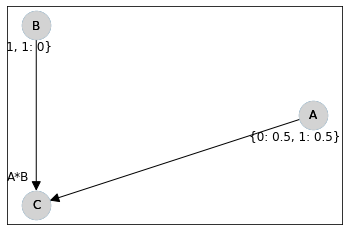

In [15]:
cbn.intervene({"B": 0})
cbn.draw()

### 5.4 Sampling

We can easily sample values from the joint distribution of the network:

In [16]:
cbn.sample()

{'A': 0, 'B': 0, 'C': 0}

## 6. Graphical properties

Finally, we cover some methods for working with the graphical structure of the network.

### 6.1 d-separation

For example, we can assess whether two nodes are d-separated when conditioning on a set of variables:

In [17]:
cbn.is_dconnected("A", "B", ["C"])

True

and an example of an active path establishing the d-connection:

In [18]:
pycid.core.get_paths.find_active_path(cbn, "A", "B", {"C"})

['A', 'C', 'B']

### 6.2 Directed paths

We can find all directed paths between two nodes:

In [19]:
list(pycid.core.get_paths.find_all_dir_paths(cbn, "A", "C"))

[['A', 'C']]